In [2]:
import matplotlib.pyplot as plt
import numpy as np
import sympy as sy
from sympy import Derivative, Symbol
from scipy.special import sph_harm 
from scipy import integrate
from scipy.integrate import dblquad
from scipy.integrate import quad

In [3]:
N_t = 50
N_p = 100
theta = np.linspace(1e-4, np.pi, N_t) #make the starting point very small
phi = np.linspace(0, 2*np.pi, N_p) 
t, p = np.meshgrid(theta, phi)
lMax = 20 #lMax is N
omega = 3.6 #omega is te angular rotation
nu = 1.5  #\nu is kinematic viscosity
T = 4 #total time
r = 1
#let r=1
#input stream function psi_TP=np.cos(t)**3*np.sin(t)*np.sin(p)**2
U_tp = -(1/r)*np.sin(t)*np.cos(t)**3*2*np.sin(p)*np.cos(p) #this is obtained by analytical calculation
V_tp = (1/r)*np.sin(t)*np.sin(p)**2*((-3)*np.cos(t)**2*np.sin(t)**2+np.cos(t)**4)

Analytical expression for U and V:

$$
U(\theta, \phi)=-\frac{1}{r} \frac{\partial \psi}{\partial \phi}
$$

$$
V(\theta, \phi)=\frac{\sin \theta}{r}\frac{\partial \psi}{\partial \theta}
$$

In [4]:
#U_tp_n is the numerical expression of U_tp
psi_TP = np.cos(t)**3*np.sin(t)*np.sin(p)**2
U_tp_n = -(1/r)*np.gradient(psi_TP, phi, axis=0)
V_tp_n = (np.sin(t)/r)*np.gradient(psi_TP, theta, axis=1)
print ("max difference between numerical and analytical calculated U\n",np.amax(np.abs(U_tp_n-U_tp)))
print ("max difference between numerical and analytical calculated V\n",np.amax(np.abs(V_tp_n-V_tp)))

max difference between numerical and analytical calculated U
 0.0205744057194443
max difference between numerical and analytical calculated V
 0.004085007883297298


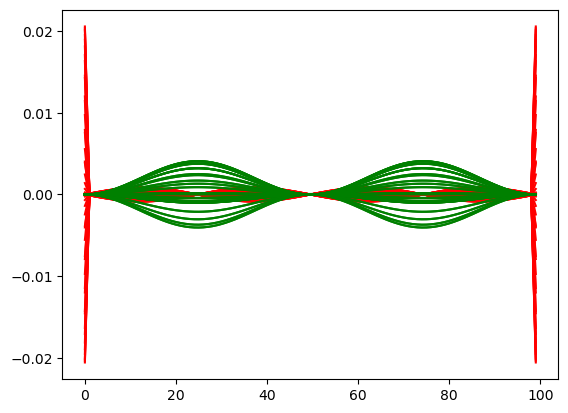

In [16]:
plt.plot(U_tp_n-U_tp, label='max difference between numerical and analytical calculated U', color='red')
plt.plot(V_tp_n-V_tp, label='max difference between numerical and analytical calculated V', color='green')

The equation used for projection of the spherical harmonics: 
$$
\begin{equation}
    \psi_{nm}=\int ^{2\pi}_0 \int^\pi_0 \psi(\theta, \phi)(Y^m_n(\theta,\phi))^\ast \sin \theta d\theta d\phi
\end{equation}
$$

In [6]:
def projection(f_tp, theta, phi, lMax): # Projection onto sph_harm: takes f(theta,phi) as input and returns f_{nm}
    t, p = np.meshgrid (theta, phi)
    f_nm = np.zeros((lMax, lMax), dtype=complex)
    for m in range (lMax): 
        for n in range (m, lMax):
            Y_nm = sph_harm (m, n, p.reshape(-1), t.reshape(-1))
            Y_ast = np.conj(Y_nm.reshape(N_p, N_t))
            f_nm[n,m] = integrate.simpson(integrate.simpson(f_tp*Y_ast*np.sin(t), theta), phi)
    return f_nm

The equation used for reconstruction:
$$
\begin{equation}
    \psi (\theta, \phi) = \sum ^{N}_{\lvert m \rvert = 0} \sum ^{N}_{n=\lvert m \rvert} \psi_{nm} Y^m_n(\theta, \phi)
\end{equation}
$$

In [7]:
def reconstruction(f_nm, theta, phi, lMax):  #Reconstruction from sph_harm, takes f_{nm} and returns f(theta,phi)
    f_TP = np.zeros((N_p, N_t))
    #double sum
    for m in range(lMax):
        for n in range(m, lMax):
            Y_nm = sph_harm (m, n, p.reshape(-1), t.reshape(-1)).reshape(N_p, N_t)
            if m==0:
                f_TP += np.real(f_nm[n,m]*Y_nm) # A+=B is equivalent to A=A+B
            else:
                f_TP += 2.*np.real(f_nm[n,m]*Y_nm) #the negative value need to also be accounted for
    return f_TP

In [8]:
u_nm = projection(U_tp, theta, phi, lMax) #project U_tp to u_nm
v_nm = projection(V_tp, theta, phi, lMax) 

In [9]:
U_TP = reconstruction(u_nm, theta, phi, lMax) #reconstructed U(theta, phi) using u_nm
V_TP = reconstruction(v_nm, theta, phi, lMax) 

In [10]:
print ("max difference between original and reconstructed U\n",np.amax(np.abs(U_TP-U_tp)))
print ("max difference between original and reconstructed V\n",np.amax(np.abs(V_TP-V_tp)))

max difference between original and reconstructed U
 0.03427679241137341
max difference between original and reconstructed V
 0.02839982457632936


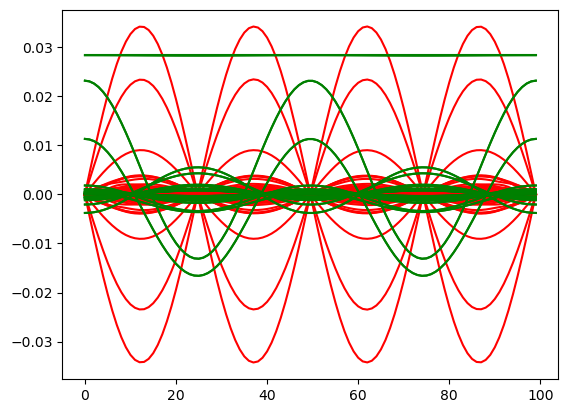

In [17]:
plt.plot(U_TP-U_tp, label='max difference between original and reconstructed U', color='red')
plt.plot(V_TP-V_tp, label='max difference between original and reconstructed V', color='green')